# Constraints
Generally, a vector-valued constraints function, $g$, defines a solution $x$ as feasible if and only if $g_i(x) \le 0$ for all $i$. In order to optimize a function with constraints, we can use the class `ConstrainedFitnessAL` which constructs an (unconstrained) augmented Lagrangian objective function from the objective and arbitrary non-linear constraints.

For some positive and changing parameters $\lambda_i, \mu_i$, the constructed function is

$$x\mapsto f(x) + \sum_i (\lambda_i g_i + \frac{\mu_i}{2}g_i^2)$$

where $g_i := \max\left(g_i(x), -\lambda_i/\mu_i\right)$. An illustration of the construced function is provided below at the end of the notebook. This construction may work poorly if a constraint is discontinuous at the feasibility boundary.

For simplicity, let's consider a single constraint that restricts the second variable to values $\le-1$ and a superfluous second constraint. 


In [1]:
import cma

fun = cma.ff.elli  # we could use `functools.partial(cma.ff.elli, cond=1e4)` to change the condition number to 1e4
def constraints(x):
    return [x[1] - -1, x[1] - -0.9]  # constrain the second variable to <= -1, the second constraint is superfluous

x0 = 4 * [2]  # initial solution
sigma0 = 1    # initial standard deviation to sample new solutions


We can use the function `cma.fmin_con2` which takes, compared to `cma.fmin2`, four _additional_ arguments after `sigma0`.

In [2]:
cma.fmin_con2?

Signature:
cma.fmin_con2(
    objective_function,
    x0,
    sigma0,
    constraints=<function no_constraints at 0x133c15440>,
    find_feasible_first=False,
    find_feasible_final=False,
    kwargs_confit=None,
    **kwargs_fmin,
)
Docstring:
optimize f with inequality constraints g.

`constraints` is a function that returns a list of constraints values,
where feasibility means <= 0. An equality constraint ``h(x) == 0`` can
be expressed as two inequality constraints like ``[h(x) - eps, -h(x) -
eps]`` with ``eps >= 0``.

`find_feasible_...` arguments toggle to search for a feasible solution
before and after the constrained problem is optimized. Because this can
not work with equality constraints, where the feasible domain has zero
volume, find-feasible arguments are `False` by default.

`kwargs_confit` are keyword arguments to instantiate
`constraints_handler.ConstrainedFitnessAL` which is optimized and
returned as `objective_function` attribute in the second return
argument (type `C

In [3]:
x, es = cma.fmin_con2(fun, x0, sigma0, constraints, options={'verb_disp_overwrite': 3})

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=578222, Mon Aug 18 12:56:11 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.611304119803833e+05 1.0e+00 9.93e-01  8e-01  1e+00 0:00.0
    2     16 9.702651124536000e+05 1.5e+00 1.12e+00  9e-01  1e+00 0:00.0
    3     24 3.868837345465594e+06 1.6e+00 1.21e+00  9e-01  2e+00 0:00.0


  228   1824 9.999999999999999e+01 1.3e+03 3.15e-06  9e-11  1e-07 0:00.2
termination on tolfun=1e-11 (Mon Aug 18 12:56:11 2025)
final/bestever f-value = 1.000000e+02 -8.720782e+05 after 1825/70 evaluations
incumbent solution: [ 3.94705737e-08, -1.00000000e+00, 2.91016115e-10, 6.60523795e-11]
std deviation: [9.54262831e-08, 3.24454375e-10, 8.88895684e-10, 9.14530271e-11]


The incumbent solution is close to the know optimal solution ``[0, -1, 0, 0]`` but it may not be feasible. The best feasible solution is accessible under `es.best_feasble.x`.

In [4]:
es.best_feasible.x

array([ 1.41158582e-08, -1.00000000e+00, -2.47303715e-10,  4.09730475e-11])

The standard plot shows linear convergence of the objective variables.

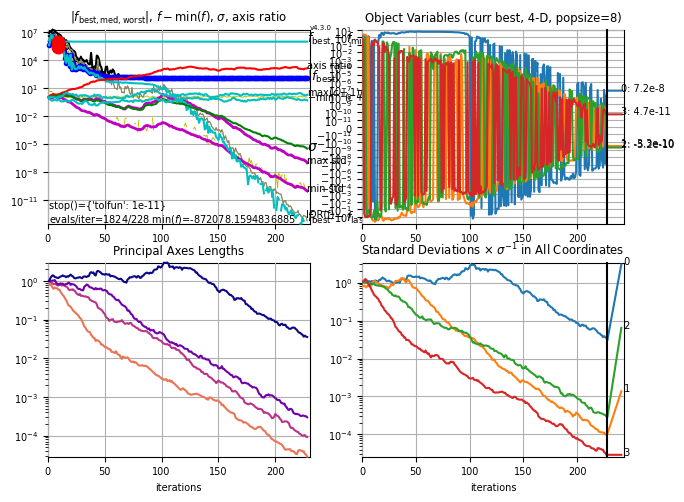

In [5]:
es.plot(xsemilog=True, x_opt=[0, -1] + (len(x0) - 2) * [0]);

The underlying code of `fmin_con2` uses the `cma.ConstrainedFitnessAL` class and calls `cma.fmin2`. We can do this explicitly too.

In [6]:
cfun = cma.ConstrainedFitnessAL(fun, constraints)  # unconstrained function with adaptive Lagrange multipliers

x, es = cma.fmin2(cfun, x0, sigma0, {'tolstagnation': 0}, callback=cfun.update)
x = es.result.xfavorite  # the original x-value may be meaningless
constraints(x)  # show constraint violation values

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=563038, Mon Aug 18 12:56:13 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 5.507873130559911e+05 1.0e+00 1.14e+00  1e+00  1e+00 0:00.0
    2     16 6.402855516465992e+06 1.5e+00 1.20e+00  1e+00  1e+00 0:00.0
    3     24 6.325254555990570e+03 1.5e+00 1.55e+00  1e+00  2e+00 0:00.0
  100    800 1.055347245167606e+02 7.7e+02 2.83e-01  1e-03  8e-01 0:00.1
  200   1600 1.000000000001072e+02 1.1e+03 1.08e-04  2e-08  2e-05 0:00.2
  247   1976 9.999999999999997e+01 8.4e+02 2.62e-06  6e-11  5e-08 0:00.2
termination on tolfun=1e-11 (Mon Aug 18 12:56:13 2025)
final/bestever f-value = 1.000000e+02 -1.551534e+06 after 1977/26 evaluations
incumbent solution: [-3.10939128e-08, -1.00000000e+00, 3.04990959e-10, -6.75709291e-12]
std deviation: [4.78065391e-08, 9.38075799e-11, 6.54784418e-10, 6.43891314e-11]


[-3.49327233806207e-11, -0.1000000000349327]

The solution `es.result.xfavorite` is expected to be close to the feasible domain, but it may not be "strictly" feasible. To find a truly feasible solution, we can run a post-optimization like

In [7]:
c = es.countiter
x = cfun.find_feasible(es)
print("find_feasible took {} iterations".format(es.countiter - c))
constraints(x)  # is now <= 0 in all compontents

find_feasible took 0 iterations


[-7.114087097193078e-12, -0.10000000000711406]

We can also plot the time evolution of feasibility and augmented Lagrangian parameters and, of course, the standard plot: 

In [8]:
# "%matplotlib widget" gives interactive inline plots (pip install --upgrade jupyterlab ipympl); CAVEAT: it does not open a new figure automatically
# fix failing variable completion: %config Completer.use_jedi = False

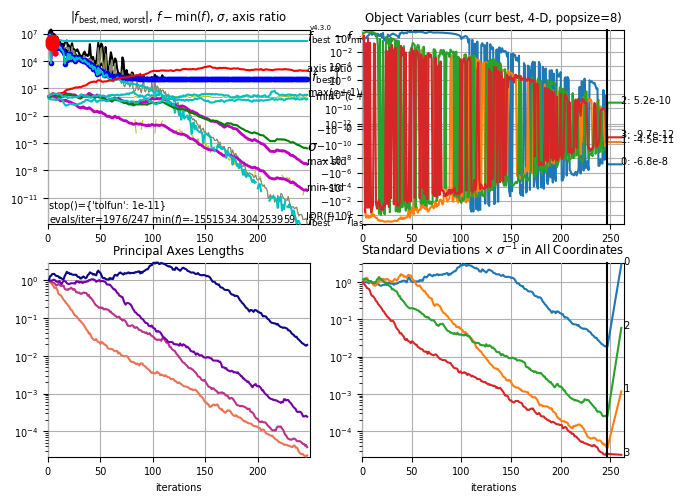

In [9]:
es.plot(xsemilog=True, x_opt=[0, -1] + (len(x0) - 2) * [0]);

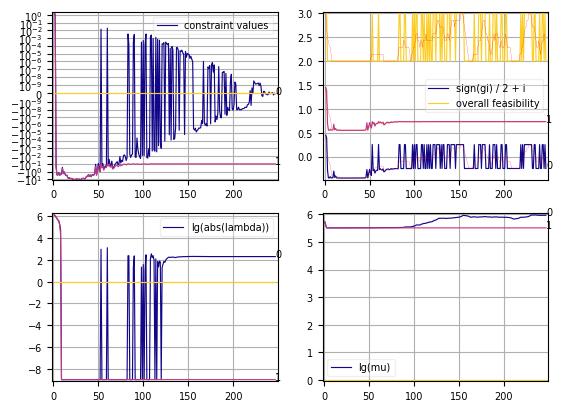

In [10]:
cfun.al.loggers.plot()

The `ConstrainedFitnessAL` class instance provides some more detailed information:

In [11]:
cfun.archives[0].archive  # non-dominated list of [f, aggregate(g)], feasible if aggregate(g) <= 0

[[99.99999999281764, 3.84943188436182e-11],
 [99.99999999605413, 2.236200113969744e-11],
 [99.99999999608153, 1.95922167378626e-11],
 [99.9999999976484, 1.1765033391952784e-11],
 [99.99999999773307, 1.1334488903003148e-11],
 [99.99999999776166, 1.1194822846505303e-11],
 [99.9999999985539, 7.230327447871332e-12],
 [99.99999999933303, 3.3347768990665827e-12],
 [99.99999999946827, 2.6594282331871e-12],
 [100.0000000014228, 0]]

In [12]:
cfun.archives[0].archive.infos[-1]

{'x': array([-1.27364245e-07, -1.00000000e+00, -6.11911366e-10, -6.69570302e-11]),
 'f': 100.0000000014228,
 'g': [-7.114087097193078e-12, -0.10000000000711406],
 'f_al': 99.99999999999999,
 'g_al': [-1.4228176546597732e-09, 0.0],
 'count': 1962}

Details about the best feasible solution can be found under its `info` attribute.


In [13]:
cfun.best_feas.info

{'x': array([-1.27364245e-07, -1.00000000e+00, -6.11911366e-10, -6.69570302e-11]),
 'f': 100.0000000014228,
 'g': [-7.114087097193078e-12, -0.10000000000711406],
 'f_al': 99.99999999999999,
 'g_al': [-1.4228176546597732e-09, 0.0],
 'count': 1962}

# Ask-and-Tell Interface
We sometimes want to directly use the `CMAEvolutionStrategy` class on which `cma.fmin2` is based to get more control over the optimization loop. In the constrained case, we can do so by simply passing the constraints values to `tell` (since v4.4.0).

In [14]:
# a verbose way to run ``_, es = cma.fmin_con2(fun, x0, sigma0, constraints)``

es = cma.CMAEvolutionStrategy(x0, sigma0)

while not es.stop():
    X = es.ask()  # sample len(X) candidate solutions
    es.tell(X, [fun(x) for x in X], constraints_values=[constraints(x) for x in X])
    es.logger.add()  # for later plotting
    es.disp()
es.result_pretty()

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=636262, Mon Aug 18 12:56:15 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 4.410184755188449e+07 1.0e+00 1.00e+00  8e-01  1e+00 0:00.0
    2     16 2.777431604959698e+06 1.3e+00 1.29e+00  1e+00  1e+00 0:00.0
    3     24 3.237799016449240e+04 1.5e+00 1.82e+00  2e+00  2e+00 0:00.0
  100    800 1.026883757061797e+02 1.5e+02 6.38e-02  4e-04  5e-02 0:00.1
  200   1600 1.000000005254802e+02 1.2e+03 2.02e-04  3e-08  3e-05 0:00.2
  260   2080 1.000000000028643e+02 1.2e+03 9.74e-07  2e-11  2e-08 0:00.3
termination on tolflatfitness=1
final/bestever f-value = 1.000000e+02 1.000000e+02 after 2080/2065 evaluations
incumbent solution: [ 1.26972996e-08, -1.00000000e+00, 5.19250512e-10, 4.95614867e-11]
std deviation: [1.78747016e-08, 1.81024024e-11, 1.03200244e-10, 1.56428727e-11]


CMAEvolutionStrategyResult(xbest=array([-2.67190173e-09, -1.00000000e+00,  6.20772059e-10,  2.96002298e-11]), fbest=100.0000000002765, evals_best=2065, evaluations=2080, iterations=260, xfavorite=array([ 1.26972996e-08, -1.00000000e+00,  5.19250512e-10,  4.95614867e-11]), stds=array([1.78747016e-08, 1.81024024e-11, 1.03200244e-10, 1.56428727e-11]), stop={'tolflatfitness': 1})

The augmented Lagrangian is now instantiated in the `augmented_lagrangian` attribute.

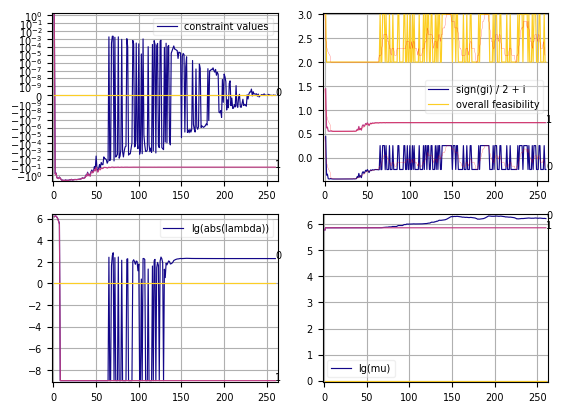

In [15]:
es.augmented_lagrangian.loggers.plot()

Or, we can use, like above, an instance of `cma.ConstrainedFitnessAL` within the `ask`-and-`tell` loop.
This requires to additionally call `cfun.update(es)`.

In [16]:
# a verbose way to run ``_, es = cma.fmin2(cfun, x0, sigma0)``

cfun = cma.ConstrainedFitnessAL(fun, constraints)  # unconstrained function with adaptive Lagrange multipliers
es = cma.CMAEvolutionStrategy(x0, sigma0)

while not es.stop():
    X = es.ask()  # sample len(X) candidate solutions
    es.tell(X, [cfun(x) for x in X])
    cfun.update(es)
    es.logger.add()  # for later plotting
    es.disp()
es.result_pretty()

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=589348, Mon Aug 18 12:56:16 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 9.466562518271670e+05 1.0e+00 9.47e-01  9e-01  9e-01 0:00.0
    2     16 8.377793615493827e+06 1.3e+00 9.52e-01  8e-01  1e+00 0:00.0
    3     24 3.584371636045683e+06 1.3e+00 1.37e+00  1e+00  1e+00 0:00.0
  100    800 1.102547586844909e+02 5.3e+02 8.38e-02  4e-04  2e-01 0:00.1
  200   1600 9.999999999999625e+01 1.1e+03 2.53e-05  3e-09  2e-06 0:00.1
  225   1800 9.999999999999997e+01 1.3e+03 1.03e-06  3e-11  4e-08 0:00.2
termination on tolfun=1e-11
final/bestever f-value = 1.000000e+02 -2.567669e+06 after 1800/33 evaluations
incumbent solution: [ 4.52138320e-08, -1.00000000e+00, 3.24927715e-10, -4.04657520e-13]
std deviation: [4.01678125e-08, 3.48349711e-11, 3.24917072e-10, 3.83195681e-11]


CMAEvolutionStrategyResult(xbest=array([-1.65196994, -4.11210597, -1.10339081, -0.85039227]), fbest=-2567669.4180795886, evals_best=33, evaluations=1800, iterations=225, xfavorite=array([ 4.52138320e-08, -1.00000000e+00,  3.24927715e-10, -4.04657520e-13]), stds=array([4.01678125e-08, 3.48349711e-11, 3.24917072e-10, 3.83195681e-11]), stop={'tolfun': 1e-11})

If the function or the constraints take additional arguments, they can be attached to the function ahead of time using [`functools.partial`](https://docs.python.org/3/library/functools.html). When the attached value is a mutable reference (like a `list`, `dict`, or `class`), it can also be changed dynamically during the optimization.

## Understanding the Augmented Lagrangian
Shown is a 1-dimensional quadratic objective function $f$ (blue), with the optimum in the infeasible domain, and a linear constraint $g$ (orange) leading to the augmented Lagrangian $x\mapsto f(x) + \lambda g + \frac{\mu}{2}g^2$ where $g := \max(g(x), -\lambda/\mu)$ shown in red. Because the coefficient $\lambda$ is slightly smaller than $-f'(x_0) / g'(x_0)$, where $x_0$ delineates feasible and infeasible domain ($g(x_0) = 0$), the optimum of the augmented Lagrangian is slightly in the infeasible domain. The quadratic function $\lambda g(x) + \frac{\mu}{2}g(x)^2$ is shown in green and the penalty term $\lambda g + \frac{\mu}{2}g^2$ is the green curve which becomes flat to the left.

![constraints-augmented](pics/constraints-augmented.png)